## Get started with Adversarial Patches on Videos

__Description__:

This notebook demonstrates how to execute physically realizable adversarial patch attacks on video data using HEART.

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load and prepare data
3. Load video classification model
4. Define the patch attack
5. Predict and visualize

## 1. Notebook imports
The following are the library imports for this notebook and a utility function for displaying videos as GIFs within the notebook

In [1]:
from art.attacks.evasion import AdversarialPatchPyTorch
from heart_library.estimators.classification import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack

from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.nn import Module
from torch import permute, tensor
from numpy.typing import NDArray
import numpy as np

from datasets import load_dataset
from io import BytesIO
from PIL import Image
import IPython.display as display

def to_gif(video: np.ndarray, mul_pixels: bool = False) -> None:
    """Convert video to gif
    
    :param video: video to convert to gif, expected in format NFCHW
    :param mul_pixels: boolean indicating if video pixels range should increase
    :return None
    """
    video = video.transpose(0,2,1,3,4)
    if mul_pixels:
        frames = [Image.fromarray(frame.transpose(1, 2, 0)) for frame in (video[0].transpose(1, 0, 2, 3)*255).astype(np.uint8)]
    else:
        frames = [Image.fromarray(frame.transpose(1, 2, 0)) for frame in (video[0].transpose(1, 0, 2, 3)).astype(np.uint8)]

    gif_data = BytesIO()
    frames[0].save(gif_data, format='GIF', save_all=True, append_images=frames[1:], loop=0, duration=100)
    gif_data.seek(0)
    display.display(display.Image(data=gif_data.read()))

## 2. Load and prepare data
The next step is to load a video dataset. Here we are loading a small sample of example "eating" videos. As the model we wish to use, the [r3d_18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r3d_18.html) was trained using the [Kinetics Human Action Video Dataset](https://arxiv.org/abs/1705.06950). 

The data is transformed as per the specifications of the model noted in documentation on Torchvision. Specifically, resizing, cropping and ensuring the pixel range is between 0 and 1.

The data conforms to the format expected by ART's AdversarialPatchPyTorch attack, `NFCHW` where:
- N: Number, or batch of videos
- F: Frames, the number of frames in the video
- C: Channels, generally 3 for RGB, 1 for grayscale
- H: Height dim of the video
- W: Width dim of the video

In [ ]:
data = load_dataset("linoyts/wan_eating", split="train[:4]")

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 171), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
])

def preprocess(video_reader, start_frame=0, end_frame=80):
    frames = video_reader.get_batch(range(start_frame, end_frame))
    frames = frames.asnumpy()
    frames = (frames / 255)
    resized_frames = np.asarray(list(map(lambda frame: resize(frame), frames)))
    return resized_frames

sample_data = []
for item in data:
    preproc_vid = preprocess(item['video'])
    sample_data.append(preproc_vid)
sample_data: NDArray[np.float32] = np.asarray(sample_data)

objc[42589]: Class AVFFrameReceiver is implemented in both /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x325aa83a8) and /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x3384cca10). One of the two will be used. Which one is undefined.
objc[42589]: Class AVFAudioReceiver is implemented in both /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x325aa83f8) and /Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/video-env/lib/python3.11/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x3384cca60). One of the two will be used. Which one is undefined.


## 3. Load video classification model

The `r3d_18` model unfortunately expects data in a different format to AdversarialPatchPyTorch attack and so we will need to create a model wrapper to transform the data prior to the forward pass. This can easily be achieved with the following cell. Note that `x` is a tensor and so we permute the correct dimension for passing to the model.

Once wrapped, we can instantiate our `JaticPyTorchClassifier`. Key to note here is the input shape, which has an extra dimension due to the time (frame) included in videos - here we have 80 frames, and our data is in "frames-first", "channels-second" format. The model was trained on `KINETICS400_V1` and so we expect 400 class labels. 

In [3]:
class MyModelWrapper(Module):
    """Model wrapper for r3d18"""
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        arr = permute(x, (0,2,1,3,4)) # format to model NCFHW shape
        outputs = self.model.forward(arr)
        return outputs

weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
_ = model.eval()


model_ = MyModelWrapper(model)
jptc = JaticPyTorchClassifier(model=model_, nb_classes=400, input_shape=(80, 3, 112, 112), loss=CrossEntropyLoss(), clip_values=(0,1),
                                     device_type="cpu")

## 4. Define the patch attack

Next, we define the attack: AdversarialPatchPyTorch and its associated parameters. Note that, currently, `patch_location` is not a supported parameter when using this attack with video data and that the _scale_ of the applied patch can be modified by passing in a value between 0 and 1 (note the default is 1, which means the patch will cover the full width and height of each frame of video). 
As `patch_location` is not fixed, multiple executions of this attack will place the patch in random locations.

In [4]:
batch_size = 16
scale_min = 0.1
scale_max = 0.5
rotation_max = 0
learning_rate = 5000.
max_iter = 5
patch_shape = (3, 75, 75)

patch_attack = AdversarialPatchPyTorch(estimator=jptc, rotation_max=rotation_max,
                      scale_min=scale_min, scale_max=scale_max, 
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, verbose=True, targeted=False)

Execute the patch attack

In [5]:
ap = JaticAttack(patch_attack)
adv_images, _, metadata = ap(sample_data, scale=0.35) # input is in format NFCHW

Adversarial Patch PyTorch:   0%|          | 0/5 [00:00<?, ?it/s]

## 5. Predict and visualize

The following cell executes model prediction on the original, benign videos. 
The video, its predicted label and confidence are printed.

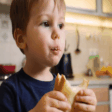

Predicted eating burger with 35.04% confidence.


In [6]:
predictions = jptc(sample_data)

probs = softmax(tensor(np.asarray(predictions)), dim=1)
label = probs[1].argmax().item()
probs = probs[1][label]*100
to_gif(sample_data[[1]], mul_pixels=True)
print(f"Predicted {weights.meta['categories'][label]} with {probs:.2f}% confidence.")

The following cell executes model prediction on the `adversarial` videos. 
The video, its predicted label and confidence are printed.
> Note that the predicted class label has now changed

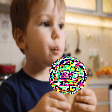

Predicted tasting food with 17.44% confidence.


In [7]:
predictions = jptc(np.asarray(adv_images))

probs = softmax(tensor(np.asarray(predictions)), dim=1)
label = probs[1].argmax().item()
probs = probs[1][label]*100
to_gif(np.asarray(adv_images)[[1]], mul_pixels=True)
print(f"Predicted {weights.meta['categories'][label]} with {probs:.2f}% confidence.")

### 6. MAITE tasks

In this section we will demonstrate how to use video data, HEART and two MAITE tasks: predict and evaluate. 

In order to run these two tasks, MAITE expects either a dataset or a dataloader. Therefore, we first create a dataset wrapper for the video data.

In [8]:
from maite.protocols import DatumMetadata, DatasetMetadata, ArrayLike
from maite.protocols.image_classification import DatumMetadataType
from typing import Optional

class VideoDatumMeta(DatumMetadata):
    """Video dataum metadata"""
    id: str

class VideoDataset:
    """Video dataset"""
    def __init__(self, data: NDArray[np.float32], labels: Optional[list[int]] = None) -> None:
        """Init dataset"""
        self.data = data
        if not labels:
            self.labels = [24, 109, 109, 131]
        self.metadata = DatasetMetadata({"id": "example", "index2label": {1: "label"}})

    def __len__(self) -> int:
        """Len of dataset"""
        return len(self.data)

    def __getitem__(self, ind: int) -> tuple[ArrayLike, ArrayLike, DatumMetadataType]:
        """Get item"""
        image: NDArray[np.float32] = self.data[ind]
        label: NDArray[np.int32] = np.array([self.labels[ind]])
        return (image, label, VideoDatumMeta({"id": "example"}))

dataset = VideoDataset(data=sample_data)

Now that we have our video dataset, we can call the ```predict``` task from MAITE. We pass our video classification model, dataset and a batch size with which to execute.


Note how the predictions differ when an attack augmentation is added in the second ```predict``` task execution - this task is executing the attack, generating adversarial samples and running model predictions on the perturbed data.

In [15]:
from maite.tasks import predict

predictions = predict(model=jptc, dataset=dataset, batch_size=2)
labels = [weights.meta['categories'][element] for row in np.argmax(np.asarray(predictions[0]), axis=2) for element in row]
print("Benign predictions", labels)

adv_predictions = predict(model=jptc, dataset=dataset, augmentation=ap, batch_size=2)
adv_labels = [weights.meta['categories'][element] for row in np.argmax(np.asarray(adv_predictions[0]), axis=2) for element in row]
print("Adversarial predictions", adv_labels)

  0%|          | 0/2 [00:00<?, ?it/s]

Benign predictions ['blowing glass', 'eating burger', 'eating burger', 'folding clothes']


  0%|          | 0/2 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/5 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/5 [00:00<?, ?it/s]

Adversarial predictions ['weaving basket', 'making pizza', 'weaving basket', 'making pizza']


Next up, we will run the MAITE ```evaluate``` task. This task takes an additional ```metric```. In this case, we use macro multi-class classification.


In the second call, we add the attack augmentation which is first run before calculating metrics on model predictions. Note the drop in performance when an attack augmentation is added.

In [16]:
from maite.tasks import evaluate
from heart_library.metrics import HeartAccuracyMetric
from typing import Any

acc_args: dict[str, Any] = {"task": "multiclass", "num_classes": 400, "average": "macro"}
metric = HeartAccuracyMetric(**acc_args)


benign_result = evaluate(model=jptc, dataset=dataset, metric=metric, batch_size=2)
print("Benign result:", benign_result)

adv_result = evaluate(model=jptc, dataset=dataset, augmentation=ap, metric=metric, batch_size=2)
print("Adversarial result:", adv_result)

  0%|          | 0/2 [00:00<?, ?it/s]

Benign result: ({'accuracy': 1.0}, [], [])


  0%|          | 0/2 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/5 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/5 [00:00<?, ?it/s]

Adversarial result: ({'accuracy': 0.0}, [], [])
